# Turning Videos into Searchable Knowledge — A Multimodal AI Pipeline
In an age where videos dominate how we learn and communicate, extracting and indexing their content is still far from easy. What if we could treat video like a searchable document?

That’s exactly what we set out to explore.

In this project, we built a multimodal AI pipeline that takes any video file and converts it into a searchable knowledge unit—by combining:

- Visual understanding through frame extraction and image embeddings

- Spoken content parsing using Whisper for transcript segmentation

- Semantic representation of both text and visuals using embeddings

- Fast similarity search with **Milvus vector database**

From YouTube videos to recorded lectures, this pipeline transforms how users interact with video content. Instead of scrubbing through long videos manually or guessing keywords, users can search using natural language or visual cues—like typing a question or uploading a relevant image—and instantly receive contextually matched video segments.

### Section 1: Import Dependencies

#### Minimum Compatible Versions You Can Use

| Component    | Minimum Version | Currently Using |
|--------------|------------------|------------------|
| **Python**   | `3.9`          | `3.10.12`        |
| **PyMilvus** | `2.5.0`          | `2.5.0`          |
| **Milvus**   | `2.5.0`          | `2.5.0`          |

#### Compatibility Notes

- **PyMilvus 2.5.x** requires **Milvus 2.5.x**
- **PyMilvus 2.5.x** supports **Python ≥ 3.9**
- Downgrading below these versions may break compatibility

Now, we'll import all necessary libraries


In [1]:
import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

from IPython.display import Image, display
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

from pymilvus import MilvusClient
from pymilvus import DataType,Function, FunctionType ,AnnSearchRequest, WeightedRanker, RRFRanker

from sentence_transformers import SentenceTransformer

from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
import cv2
import whisper

### Section 2: Initialize the constants

In [2]:
fmt = "\n=== {:30} ===\n"

# videos are downloaded from publicly available IBM website, the working links are given in the map below
video_link_map = {
    "content_generation.mp4": "https://mediacenter.ibm.com/id/1_yola7kmy",
    "insight_extraction_forecasting.mp4": "https://mediacenter.ibm.com/id/1_94hkc1fd",
    "knowledge_management.mp4": "https://mediacenter.ibm.com/id/1_vli0kaic",
    "governance.mp4": "https://mediacenter.ibm.com/media/AI+workflow+with+watsonx/1_8i4add5u"
}

### Section-3 Initialise the Models

- **CLIPModel (openai/clip-vit-base-patch32)** - Converts extracted video frames into image embeddings for similarity search.Embedding Size: 512
- **whisper.load_model("small")** - Transcribes audio from video into text (used to align speech with frames).
- **SentenceTransformer("all-MiniLM-L6-v2")** - Converts transcript segments into vector form for efficient text-based search and retrieval.Embedding Size: 384


In [3]:
# Clip Model for creating image embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load the model (you can use "tiny", "base", "small", "medium", or "large") -> these are different models.We can choose whichever we want.
# We also have some models for english only like -> tiny.en, base.en
model1 = whisper.load_model("small")

# Text Model for creating text embeddings from the transcripts
text_model = SentenceTransformer("all-MiniLM-L6-v2")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Section-4 Prepare Data

The function extract_all_frames(video_path, fps=3) extracts frames from a video file at a custom frame rate (default 3 frames per second), along with their timestamps.
If the video is having 30fps, then every 10th frame is picked. Since a lot of frames are available per second which are also very similar, we do not want to pick each and every frame.

In [4]:
def extract_all_frames(video_path, fps=3):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    count = 0
    success = True

    while success:
        success, frame = cap.read()
        if not success:
            break
        timestamp = count / frame_rate
        if int(count % (frame_rate // fps)) == 0:
            frames.append((frame, timestamp))
        count += 1
    cap.release()
    return frames

The function **generate_embedding()** takes a frame and creates an embedding for that given frame

In [5]:
def generate_embedding(frame):
    image = Image.fromarray(frame[0])
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

    return outputs.cpu().numpy()[0]

This function **get_distinct_frames()** takes a no of frames within a given time segment and we choose the top 3 distinct frames from among them.

- The idea is if a time script is running form 0-3 seconds, we pick the 3 most frames for this time frame
- This can be changed to 4,5 or more or made dynamic based on the usage

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_distinct_frames(frames_in_segment, top_k=3):
    if len(frames_in_segment) <= top_k:
        return frames_in_segment
    
    embeddings = [generate_embedding(f[0]) for f in frames_in_segment]
    similarity_matrix = cosine_similarity(embeddings)

    # Compute average similarity for each frame to others
    avg_similarities = similarity_matrix.mean(axis=1)
    
    # Select top_k frames with **lowest** average similarity (most distinct)
    distinct_indices = np.argsort(avg_similarities)[:top_k]
    
    return [frames_in_segment[i] for i in distinct_indices]

The function **store_frame_embedding_and_image()** processes a video file and its transcript to extract relevant frames based on the transcript segments, generate image and text embeddings.It stores all relevant metadata and embeddings in a pandas DataFrame for further processing (e.g., insertion into Milvus for similarity search).

The df has following columns:
- Id column with the content video_id_idx_i
- Video_id with the content as the video name
- Video_link which is generated from the map along with the corresponding timestamp using the video_id
- Image_embedding 
- Frame_data
- Timestamp
- Text text generated using the whisper model from the video
- Text_embedding 

In [7]:
def new_store_frame_embedding_and_image(video_path, transcript_segments, video_link_map, top_k=3):
    # Extract the video file name to use as a unique identifier
    video_id = os.path.basename(video_path)

    all_frames = extract_all_frames(video_path)
    data = []

    print("Got all the frames, now proceeding to create df from these")
    # Iterate through each transcript segment
    for idx, (start, end, text) in enumerate(transcript_segments):
        # Get frames that fall within the current transcript time window
        segment_frames = [f for f in all_frames if start <= f[1] <= end]

        # Select top_k most visually distinct frames from this segment
        selected_frames = get_distinct_frames(segment_frames, top_k=top_k)

        # For each selected frame in the segment
        for i, (frame, timestamp) in enumerate(selected_frames):
            image_emb = generate_embedding(frame) 
            text_emb = text_model.encode(text)     
            base_url = video_link_map.get(video_id, "unknown")  # Get video base URL, fallback to "unknown" if missing

            data.append((
                f"{video_id}_{idx}_{i}",                # Unique ID for this frame
                video_id,                               # ID of the video
                f"{base_url}#t={int(timestamp)}",       # Video link with timestamp for quick jump
                image_emb,                              # Image embedding
                round(timestamp, 2),                    # Frame timestamp
                text,                                   # Transcript segment text
                text_emb                                # Text embedding
            ))

    # Convert collected data into a DataFrame
    return pd.DataFrame(data, columns=[
        "id", "video_id", "video_link", "image_embedding", 
        "frame_timestamp", "text", "text_embedding"
    ])

The function **load_image_as_array()** is used to create numpy array from the given user input. We pass this array to generate the image embeding

In [8]:
def load_image_as_array(image_path):
    image = Image.open(image_path).convert("RGB")     # ensure 3 channels
    image_array = np.array(image)                     # shape: (H, W, 3), dtype=uint8
    return image_array

**Create_Transcripts()** takes a video and generates the transcripts using the whisper model

In [9]:
def create_transcripts(local_video_path):
    # Transcribe with timestamps
    result = model1.transcribe(local_video_path)  # can be .mp3 or .wav too

    # View segments with timestamps
    for segment in result['segments']:
        print(f"[{segment['start']:.2f}s - {segment['end']:.2f}s] {segment['text']}")
    
    return result["segments"]

def parse_transcript_segments(segments):
    return [(seg["start"], seg["end"], seg["text"].strip()) for seg in segments]

### Section 5: Using Milvus

#### 5.1: Create Collection
This function creates a Milvus collection to store and index text and image embeddings from video content, enabling powerful multimodal search using semantic, visual, and keyword-based retrieval.


In [10]:
def create_collection(milvus_client,collection_name):
    schema = milvus_client.create_schema(
        auto_id=False,
        enable_dynamic_fields=True,
        description="Multimodal audio+image embeddings",
    )

    schema.add_field(field_name="id", datatype=DataType.VARCHAR, is_primary=True, auto_id=False,max_length=1000)
    schema.add_field(field_name="video_id", datatype=DataType.VARCHAR, max_length=512,nullable=True)
    schema.add_field(field_name="video_link", datatype=DataType.VARCHAR, max_length=1024,nullable=True)
    schema.add_field(field_name="text", datatype=DataType.VARCHAR, max_length=10000,enable_analyzer=True)
    schema.add_field(field_name="text_embedding", datatype=DataType.FLOAT_VECTOR, dim=384)
    schema.add_field(field_name="image_embedding", datatype=DataType.FLOAT_VECTOR, dim=512)
    schema.add_field(field_name="sparse_embedding", datatype=DataType.SPARSE_FLOAT_VECTOR)
    schema.add_field(field_name="timestamp", datatype=DataType.INT64)

    bm25_function = Function(
        name="text_bm25_emb",
        input_field_names=["text"], 
        output_field_names=["sparse_embedding"],
        function_type=FunctionType.BM25,
    )
    schema.add_function(bm25_function)

    print(fmt.format("Create collection `audio_image_collection`"))

    milvus_client.create_collection(
        collection_name=collection_name, 
        schema=schema,
        consistency_level="Strong"
    )

#### 5.2: Insert Data into Milvus Collection

**milvus_insert_collection()** ingests data from the dataframe to milvus collection.

In [11]:
def milvus_insert_collection(milvus_client, collection_name, df, batch_size=5):
    batch = []

    for idx, (_, row) in enumerate(df.iterrows(), start=1):
        entity = {
            "id": row["id"],
            "video_id": row["video_id"],
            "video_link": row["video_link"],
            "text": row["text"],
            "text_embedding": row["text_embedding"],
            "image_embedding": list(map(float, row["image_embedding"])),
            "timestamp": int(row["frame_timestamp"]),
        }
        batch.append(entity)

        if idx % batch_size == 0 or idx == len(df):
            insert_result = milvus_client.insert(
                collection_name=collection_name,
                data=batch,
            )
            print(f"Inserted batch ending at index {idx}: {insert_result.keys()}")
            batch = []  # reset for next batch

#### 5.3: Create Index on the collection

**milvus_create_index()** Creates index for the columns in the collection namely for:

- id column
- image_embedding column
- sparse_embedding column
- text_embedding column

In [12]:
def milvus_create_index(milvus_client,collection_name):
    print(fmt.format("Start Creating index HNSW"))
    index_params = milvus_client.prepare_index_params()

    index_params.add_index(
        field_name="id"
    )

    index_params.add_index(
        field_name="image_embedding", 
        index_type="HNSW",
        metric_type="COSINE",
        params={
        "M": 64, # Maximum number of neighbors each node can connect to in the graph
        "efConstruction": 100 # Number of candidate neighbors considered for connection during index construction
        }
    )

    index_params.add_index(
        field_name="sparse_embedding",
        index_type="SPARSE_INVERTED_INDEX", 
        metric_type="BM25"
    )

    index_params.add_index(
        field_name="text_embedding", 
        index_type="HNSW",
        metric_type="COSINE",
        params={
        "M": 64, # Maximum number of neighbors each node can connect to in the graph
        "efConstruction": 100 # Number of candidate neighbors considered for connection during index construction
        }
    )


    milvus_client.create_index(
        collection_name=collection_name,
        index_params=index_params
    )

#### 5.4: Load() and Drop() Collection

- Load() is for loading the collection into memory for search
- Drop() is to delete the collection from milvus altogether

In [13]:
def drop_milvus_collection(milvus_client,collection_name):
    milvus_client.drop_collection(collection_name)


def milvus_load_collection(milvus_client, collection_name):
    print(fmt.format("Start loading"))
    milvus_client.load_collection(collection_name)

#### 5.5: Perform Hybrid Search

Here, we perform hybrid search using the image_embedding, text_embedding and text matching using the sparse embedding

In [14]:
def perform_hybrid_search(collection_name, milvus_client, image_path, query_text, query_filter, top_k=3):
    ranker = RRFRanker(100)

    milvus_client.load_collection(collection_name)

    image_array = load_image_as_array(image_path)
    dense_embedding = generate_embedding(image_array) # returns np.array of shape [512]
    text_embedding = text_model.encode(query_text)

    search_param_1 = {
        "data": [dense_embedding],
        "anns_field": "image_embedding",
        "param": {
            "metric_type": "COSINE",
            "params": {"nprobe": 10}
        },
        "limit": top_k
    }

    request_1 = AnnSearchRequest(**search_param_1)

    search_param_2 = {
        "data": [query_filter],
        "anns_field": "sparse_embedding",
        "param": {
            'params': {'drop_ratio_search': 0.2},
        },
        "limit": top_k
    }

    request_2 = AnnSearchRequest(**search_param_2)

    search_param_3 = {
        "data": [text_embedding],
        "anns_field": "text_embedding",
        "param": {
            "metric_type": "COSINE",
            "params": {"nprobe": 10}
        },
        "limit": top_k
    }

    request_3 = AnnSearchRequest(**search_param_3)

    reqs = [request_1, request_2, request_3]
    # Sparse embedding from text (BM25)
    
    res = milvus_client.hybrid_search(
        collection_name,
        reqs,
        ranker=ranker,
        limit= top_k,
        output_fields=["id", "text", "timestamp","video_link"]
    )

    print("Retrieved Results:")

    for hits in res:
        for hit in hits:
            print(f"Frame: {hit.entity.get('id')}, Score: {hit.distance}, Text: {hit.entity.get('text')}, video_link: {hit.entity.get('video_link')}")

### Section 6: Preparing the data frame and performing data ingestion in milvus

- We see the content of the given working directory. The videos are downloaded here.
- Initiate a milvus client
- Drop existing milvus collection
- Create a new milvus collection
- For each video in the directory, we create a data frame and ingest into milvus
- After successful ingestion we do a create_index and load collection


In [15]:
collection_name="Collection_test"

initial_path = "/root/full_text/videos"
contents = os.listdir(initial_path)

_URI = f"https://localhost:19530"  # Construct URI from host and port

milvus_client = MilvusClient(uri=_URI, user='ibmlhadmin', password='password',secure=True,
                        server_field_name='localhost',
                        server_pem_path='/root/dev_edition.crt')



drop_milvus_collection(milvus_client,collection_name)

create_collection(milvus_client,collection_name)

for item in contents:
    x = initial_path+"/"+item
    print(x)
    segments = create_transcripts(x)
    transcript_segments = parse_transcript_segments(segments)

    print(transcript_segments)

    df = new_store_frame_embedding_and_image(video_path=x,transcript_segments=transcript_segments,video_link_map=video_link_map)

    with pd.option_context('display.max_columns', None):
        print(df.head())
        print("Creation of Data Frame completed, now we will insert data in milvus \n \n \n")

    milvus_insert_collection(milvus_client,collection_name,df)
    
milvus_create_index(milvus_client,collection_name)

milvus_load_collection(milvus_client,collection_name)


[Connect] Connecting alias=7138d7ed9d4e4f0992437338368d8ff2 with kwargs={'uri': 'https://localhost:19530', 'timeout': None, 'secure': True, 'server_field_name': 'localhost', 'server_pem_path': '/root/dev_edition.crt'}
[ConnectMilvus] Setting up gRPC handler for alias=7138d7ed9d4e4f0992437338368d8ff2
[ConnectMilvus] Waiting for gRPC channel to become READY (timeout=10.0)
[ConnectMilvus] Connection registered for alias=7138d7ed9d4e4f0992437338368d8ff2
[FetchHandler] Looking up connection alias=7138d7ed9d4e4f0992437338368d8ff2
[FetchHandler] Looking up connection alias=7138d7ed9d4e4f0992437338368d8ff2

=== Create collection `audio_image_collection` ===

[FetchHandler] Looking up connection alias=7138d7ed9d4e4f0992437338368d8ff2
/root/full_text/videos/insight_extraction_forecasting.mp4


/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[0.00s - 6.92s]  WatsonX.ai gives you the power to tailor foundation models for specific enterprise use cases,
[6.92s - 10.92s]  such as extracting information from large complex documents.
[10.92s - 13.32s]  Let's see how it works.
[13.32s - 17.96s]  In the Prompt Lab, you'll find a Fact Extraction Sample Prompt, which is designed to uncover
[17.96s - 22.52s]  specific information from an SCC 10K filing.
[22.52s - 26.84s]  You can provide natural language instructions, like extract the line of credit borrowing
[26.84s - 29.62s]  capacity from the 10K filing.
[29.62s - 35.82s]  You can also add examples, which helps tailor the model's response.
[35.82s - 39.74s]  Simply click Generate, and the model reads through the document and extracts the requested
[39.74s - 44.22s]  information, which saves you from a time-consuming manual task.
[44.22s - 48.58s]  The sample prompts default to the large language model most appropriate for the specific use
[48.58s - 50.26s]  case.
[50.26s - 55.14s]

/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0.00s - 8.00s]  With WatsonX.ai, you can leverage retrieval augmented generation to build a question and answer application.
[8.00s - 15.00s]  Let's see how you can generate accurate answers from a broad external knowledge base via vector embedding connections.
[15.00s - 22.00s]  In the prompt lab, you can begin prompt engineering in either a structured or freeform format.
[22.00s - 34.00s]  Simply add your content, including training examples, and ask the model a question, such as, according to the below document, what did IBM accomplish in 2022?
[34.00s - 41.00s]  You can select the best large language model for your use case and adjust its decoding settings.
[41.00s - 50.00s]  For instance, you can increase or decrease the maximum token's return, set a repetition penalty, or add a stop sequence.
[50.00s - 61.00s]  Click Generate, and the large language model associated with the sample prompt quickly returns relevant information by accessing facts from the external knowledge base.
[

/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0.00s - 11.00s]  WatsonX.ai empowers developers and model builders to experiment with foundation models for enterprise AI use cases, including content and code creation.
[11.00s - 14.00s]  Let's see how it works.
[14.00s - 22.00s]  In the Prompt Lab, there are several content generation sample prompts, including one for a marketing email.
[22.00s - 31.00s]  The sample prompts default to the most suitable large language model for the specific use case. You can adjust the model's parameters to suit your needs.
[31.00s - 40.00s]  For example, you can set a repetition penalty or change the maximum number of tokens returned.
[40.00s - 45.00s]  Alternatively, you can choose an entirely different model to experiment with.
[45.00s - 52.00s]  Simply input the information you want to include. No finesse or punctuation required.
[52.00s - 58.00s]  Click Send, and the generative model quickly returns usable content.
[58.00s - 65.00s]  You can explore the associated curl command in just a few clic

/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0.00s - 6.28s]  So let's take a look now of how an entire AI workflow end to end works in the platform.
[6.28s - 11.20s]  The lifecycle consists of preparing our data, using it to train the model, validate the
[11.20s - 15.76s]  model, tune it, and deploy in applications and solutions.
[15.76s - 17.46s]  So let's start with data preparation.
[17.46s - 22.32s]  So say you're a data scientist and want to access the data that is in a public cloud,
[22.32s - 27.44s]  some that is on-prem, some that may be in another external base, or in a public cloud,
[27.44s - 32.72s]  a second one, or anywhere else outside your hybrid cloud platform.
[32.72s - 37.52s]  So you access the platform from your laptop and invoke what's next.data.
[37.52s - 43.16s]  It establishes the necessary connections between the data sources so you can access the data
[43.16s - 44.16s]  easily.
[44.16s - 50.36s]  We've been building our IBM data pile, combining raw data collected from public sources with
[50.36s - 52.36

#### 6.1: Performing hybrid search using milvus

In [17]:
queries = [
{"image": "/root/full_text/vela.png", "filter": "IBM Vela","text": "What does IBM Vela do?"},
]

for query in queries:
    print(f"\nQuery:")
    print(f"Text: {query['text']}")
    print(f"Image: {query['image']}")
    print("-" * 50)

    perform_hybrid_search(
        collection_name=collection_name,
        milvus_client=milvus_client,
        image_path=query["image"],
        query_filter=query["filter"],
        query_text=query["text"],
        top_k=3
    )


Query:
Text: What does IBM Vela do?
Image: /root/full_text/vela.png
--------------------------------------------------
[FetchHandler] Looking up connection alias=7138d7ed9d4e4f0992437338368d8ff2


[FetchHandler] Looking up connection alias=7138d7ed9d4e4f0992437338368d8ff2
Retrieved Results:
Frame: governance.mp4_50_1, Score: 0.0197049118578434, Text: In this case, it runs on IBM Vela., video_link: https://mediacenter.ibm.com/media/AI+workflow+with+watsonx/1_8i4add5u#t=216
Frame: governance.mp4_50_2, Score: 0.0196097269654274, Text: In this case, it runs on IBM Vela., video_link: https://mediacenter.ibm.com/media/AI+workflow+with+watsonx/1_8i4add5u#t=216
Frame: governance.mp4_50_0, Score: 0.019512660801410675, Text: In this case, it runs on IBM Vela., video_link: https://mediacenter.ibm.com/media/AI+workflow+with+watsonx/1_8i4add5u#t=216


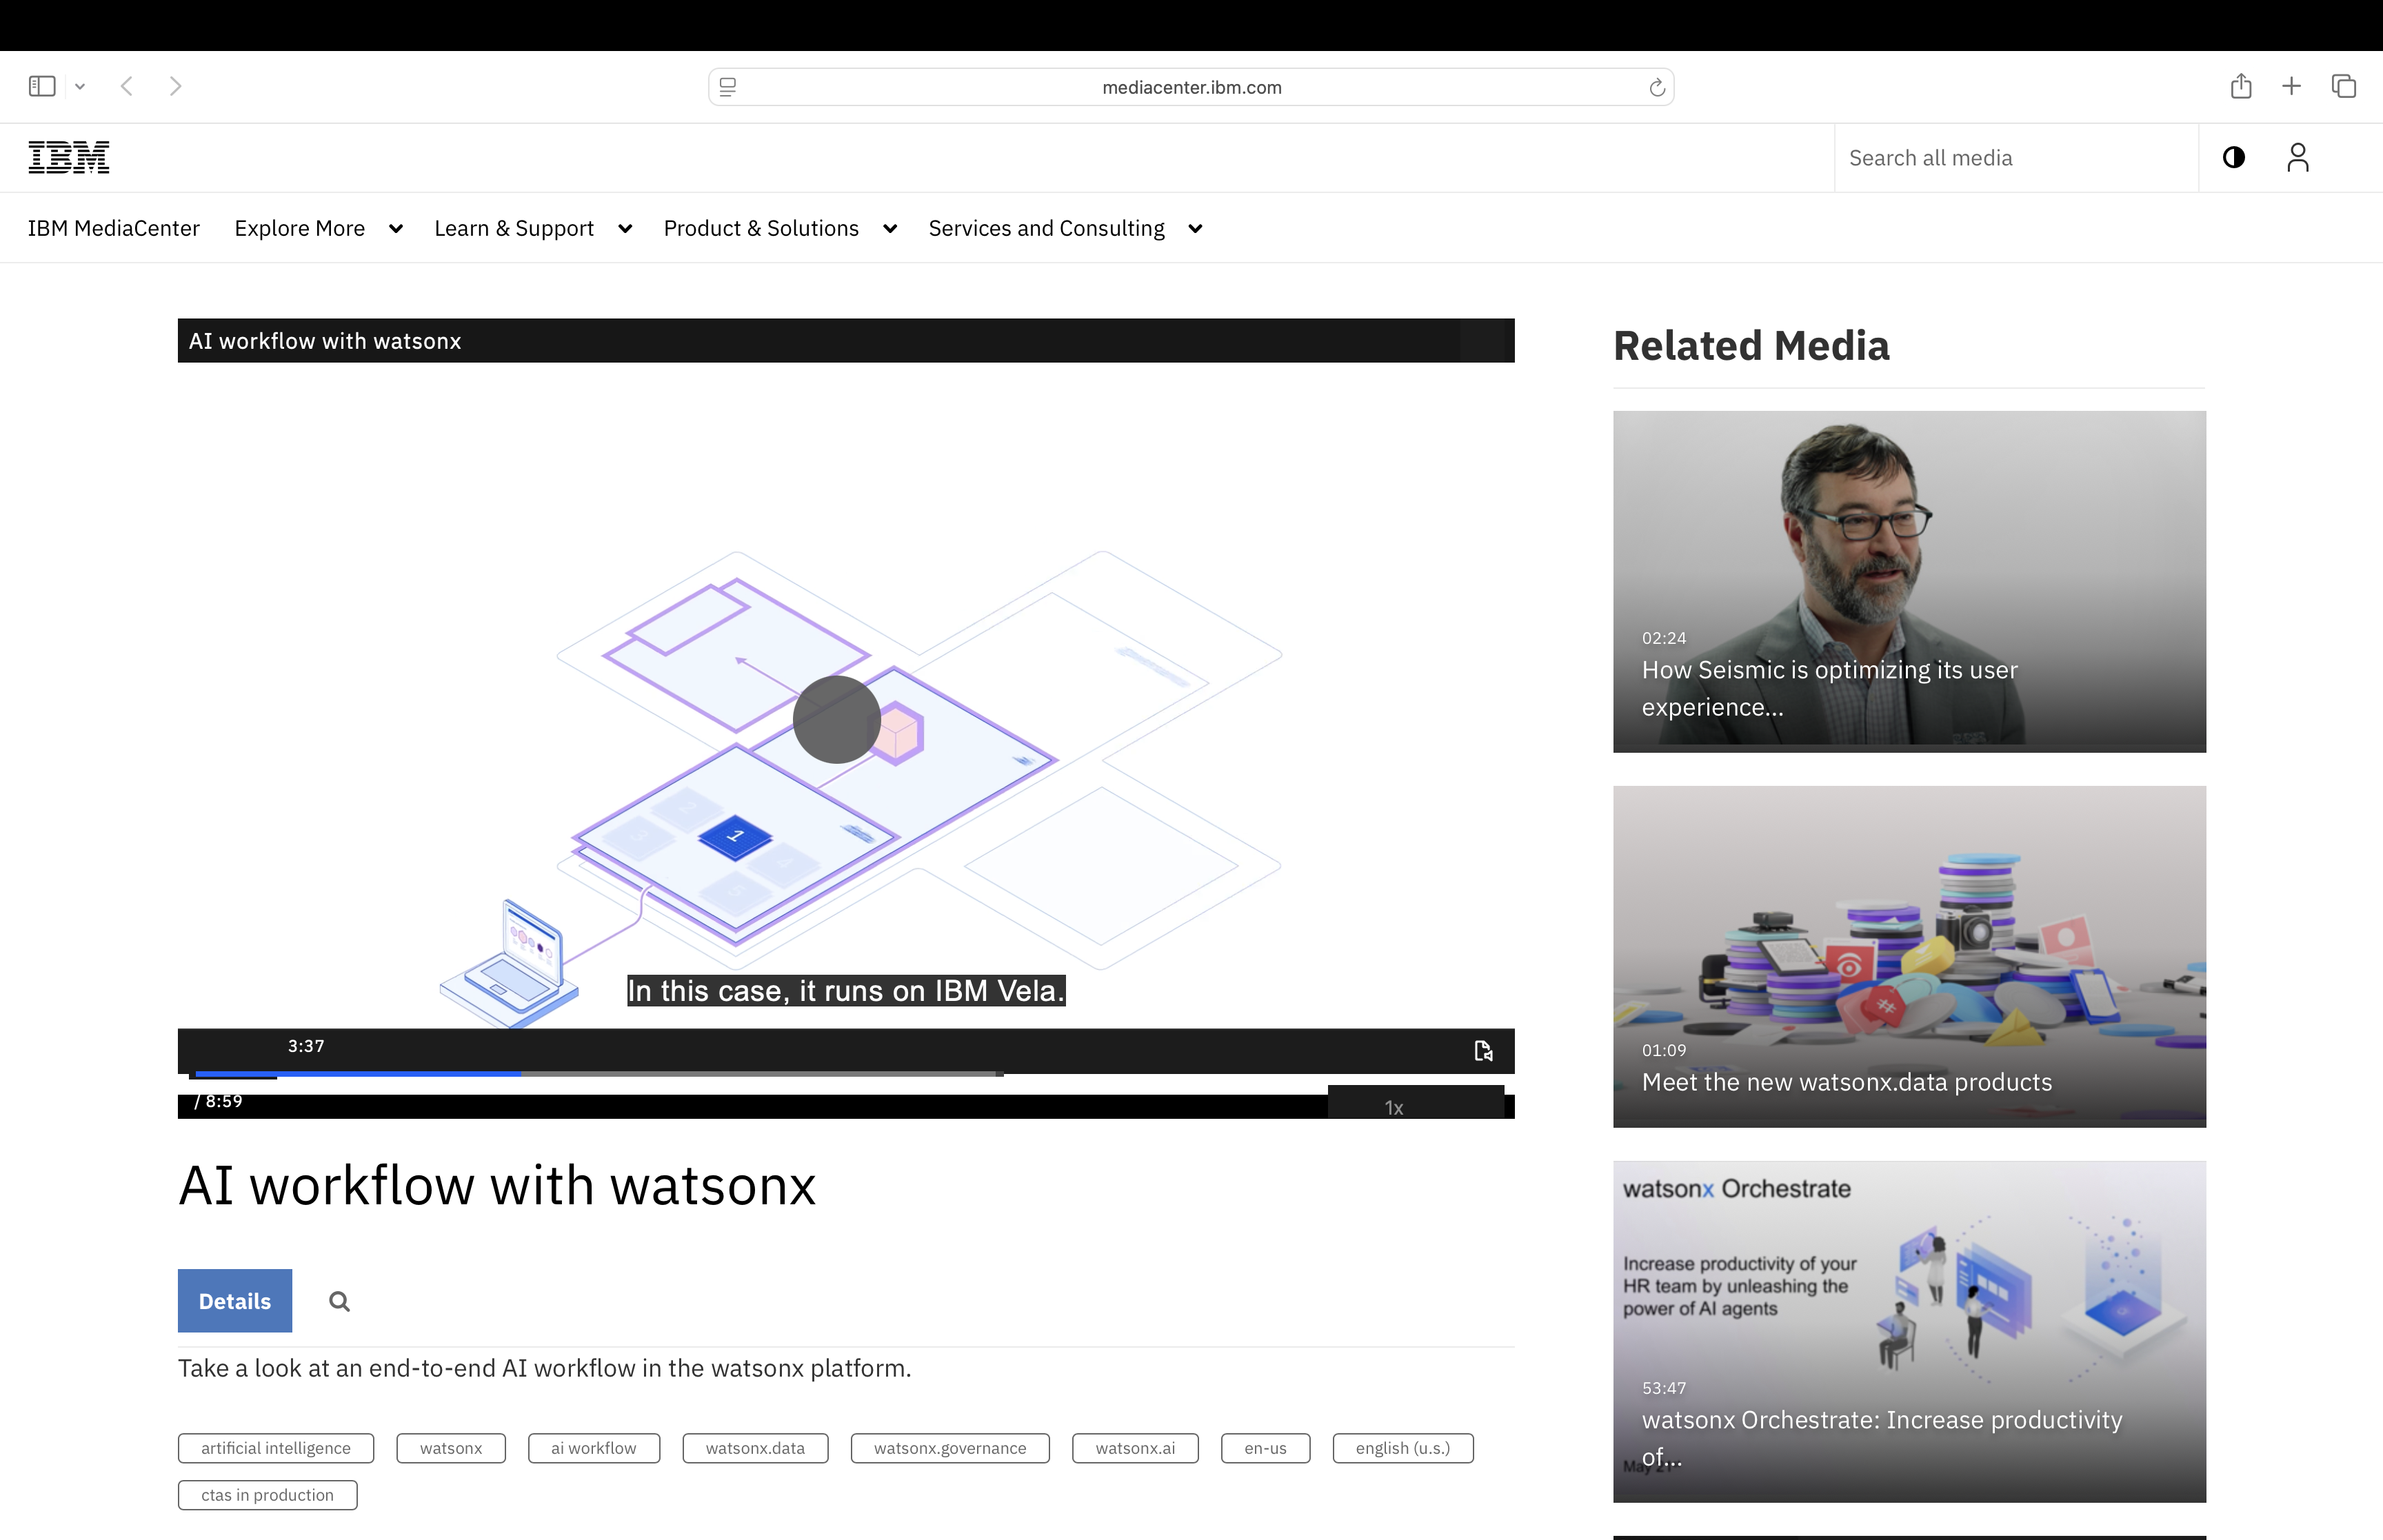

In [6]:
from IPython.display import Image

# This is the output image from the video after we click on the above link
Image(filename="/root/full_text/output.png")